In [74]:
#### Saliency notebook
#### Takes an image and visualizes its saliency prediction

import os
import sys
import io
import time

import torch
import torchvision
import torch.nn.functional as nnF
import torchvision.transforms.functional as F
import numpy as np
import pandas as pd
from PIL import Image

##Load saliency related packages
import matplotlib.pyplot as plt
from saliency_backbone import PNAS
from collections import OrderedDict
from saliency_backbone.SimpleNet.model import PNASModel
from saliency_backbone.SimpleNet.dataloader import TestLoader

# turn off axis ticks
#plt.tick_params(axis="both", which="both", length=0, width=0)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def preprocess_img(img, i, j, h, w):
    # i, j, h, w = 0, 0, 7.0/8 * 512, 14.0/8 * 512
    img = F.crop(img, i, j, h, w)
    #img = F.resize(img, 256, torchvision.transforms.InterpolationMode.BICUBIC)
    img = F.to_tensor(img)
    return img

def resize_img(img, h, w):
    # i, j, h, w = 0, 0, 7.0/8 * 512, 14.0/8 * 512
#     img = F.crop(img, i, j, h, w)
    img = F.resize(img, [h,w], torchvision.transforms.InterpolationMode.BICUBIC)
    img = F.to_tensor(img)
    return img
#TODO: Ask about resizing and center cropping. I need force resize the image to (256,256) without any cropping.

def normalize_imagenet(img):
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return img


img = Image.open('example_images/gnochi_mirror.jpeg')
print(img.size)
img_tensor = preprocess_img(img, 0, 0, img.size[1], img.size[0]).unsqueeze(0).to(DEVICE)
print(img_tensor.shape)


(960, 1280)
torch.Size([1, 3, 1280, 960])


In [59]:
# Load VGG and extract features for perceptual loss
from utils import hook_model

def load_vgg():
    vgg = torchvision.models.vgg16(pretrained=True)
    vgg.eval()
    vgg.to(DEVICE)
    return vgg

# load the pretrained VGG
vgg_model = load_vgg()

# Hook the model to reach its middle layers
vgg_hook, vgg_layers = hook_model(vgg_model, True)

# Forward pass to activate the hook
_ = vgg_model(normalize_imagenet(img_tensor))

# Choose a layer from vgg_layers.keys()
f_layer = 'features-30:MaxPool2d'

# Extract the features
feats = vgg_hook(f_layer).float()
print(feats.shape)


torch.Size([1, 512, 40, 30])


In [60]:
############PREDICT SALIENCY###################

#Load pretrained saliency model
print("Saliency PNAS Model is loading")
model = PNASModel()
model_path = "/sinergia/bahar/visual-int/visintproject/prompt-to-prompt/saliency_backbone/salicon_pnas.pt"
state_dict = torch.load(model_path)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
            if 'module'  in k:
                k = k.replace('module.', '', )
            new_state_dict[k] = v
model.load_state_dict(new_state_dict)
model = model.to(DEVICE)

#Load images with dataloader
val_img_dir = "/sinergia/bahar/visual-int/visintproject/prompt-to-prompt/example_images"
val_img_ids = os.listdir()
val_dataset = TestLoader(val_img_dir, val_img_ids)
#vis_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=args.no_workers)


Saliency PNAS Model is loading
AAAAA
96 96 54
96 270 108
270 540 216
540 1080 216
1080 1080 216
1080 1080 216
1080 1080 432
1080 2160 432
2160 2160 432
2160 2160 432
2160 2160 864
2160 4320 864
4320 4320 864
4320 4320 864


In [82]:
#Read one image to test
img = Image.open('example_images/gnochi_mirror.jpeg')
print(img.size)
img_w, img_h = (256,256)
img_tensor = resize_img(img, img_w, img_h).unsqueeze(0).to(DEVICE)
print(img_tensor.shape)

img_input = normalize_imagenet(img_tensor)
out = model(img_input)
print(out.shape)

(960, 1280)
torch.Size([1, 3, 256, 256])
torch.Size([1, 256, 256])


torch.Size([3, 256, 256])


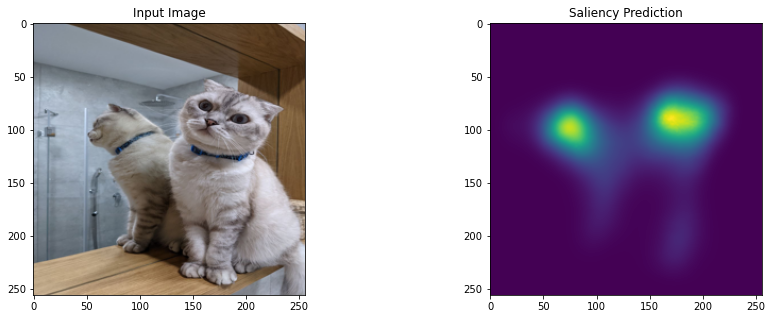

In [83]:

# Create a figure and display the image

plt.subplots(1,2, figsize=(15,5))
plt.subplot(1,2,1)
print(img_tensor.squeeze(0).shape)
plt.imshow(img_tensor.cpu().squeeze(0).permute(1,2,0).detach().numpy())
plt.title(f'Input Image')
plt.subplot(1,2,2)
plt.imshow(out.cpu().permute(1,2,0).detach().numpy())
plt.title(f'Saliency Prediction')

# Show the figure
plt.show()